In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit
plt.style.use(['science', 'notebook'])

Get coordinates of voxels

In [14]:
coords = x,y,z = np.loadtxt('../../input/turk2.txt', unpack=True, delimiter=',', dtype=int)

Plot

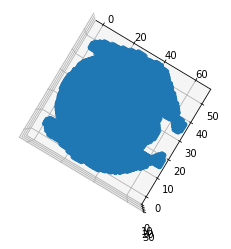

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)
ax.view_init(elev=90)

In [16]:
img = np.zeros([int(max(z)+1), int(max(y)+1), int(max(x)+1)])
np.put(img, np.ravel_multi_index(np.flip(coords), img.shape), 1)
img = np.pad(img, pad_width=1, mode='constant',
               constant_values=0)

Create boolean array

In [17]:
turkey_bool = img>0.5

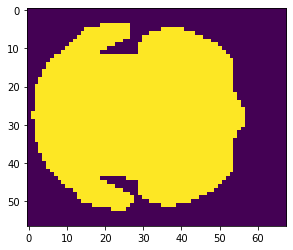

In [18]:
plt.imshow(turkey_bool[10])

In [19]:
rawturk_temp = 273.15 + 25
oven_temp = 273.15 + 165

In [20]:
init_heat = np.zeros(img.shape) + oven_temp
init_heat[turkey_bool] = rawturk_temp

In [21]:
times = 36000
times_snapshot = 3600
f = int(times/times_snapshot)
heat_frames = np.zeros([times_snapshot, *img.shape])
heat_frames[0] = init_heat

In [22]:
x = 0.4
dx = x/img.shape[2]
dy = dz = dx
dt = 1
a = 1.32e-7

In [23]:
a * dt / dx**2

0.0038148

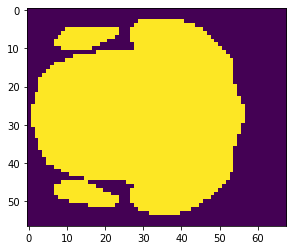

In [24]:
plt.imshow(turkey_bool[-21])

In [25]:
@numba.jit("f8[:,:,:,:](f8[:,:,:,:], b1[:,:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_turkey):
    cs = heatmap[0].copy() #current state
    lz, ly, lx = cs.shape
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, lx-1):
            for j in range(1, ly-1):
                for k in range(1,lz-1):
                    if is_turkey[k][j][i]:
                        ns[k][j][i] = cs[k][j][i] + a*dt/dx**2 * (cs[k][j+1][i] + cs[k][j-1][i] +\
                                                        cs[k+1][j][i] + cs[k-1][j][i] +\
                                                        cs[k][j][i+1] + cs[k][j][i-1] -\
                                                        6*cs[k][j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

In [26]:
heat_frames = solve_heat(heat_frames, turkey_bool)

In [27]:
heat_frames -= 273.15

In [28]:
t = np.linspace(0, 10, len(heat_frames))

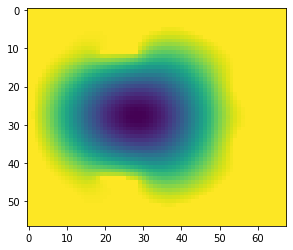

In [29]:
plt.imshow(heat_frames[-1][10])

In [35]:
heat_frames[3599][10]

array([[165., 165., 165., ..., 165., 165., 165.],
       [165., 165., 165., ..., 165., 165., 165.],
       [165., 165., 165., ..., 165., 165., 165.],
       ...,
       [165., 165., 165., ..., 165., 165., 165.],
       [165., 165., 165., ..., 165., 165., 165.],
       [165., 165., 165., ..., 165., 165., 165.]])

Text(0.5, 1.0, 'Time = 1.86 hours')

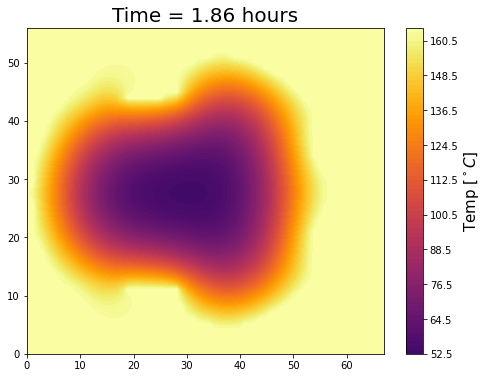

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
a = ax.contourf(heat_frames[10*67][10], 100, cmap=my_cmap,
                    vmin=rawturk_temp-273.15, vmax = oven_temp-273.15)
cbar = fig.colorbar(a)
cbar.set_label('Temp [$^\circ C$]', fontsize=15)
ax.set_title('Time = {:.2f} hours'.format(100*67/3600), fontsize=20)

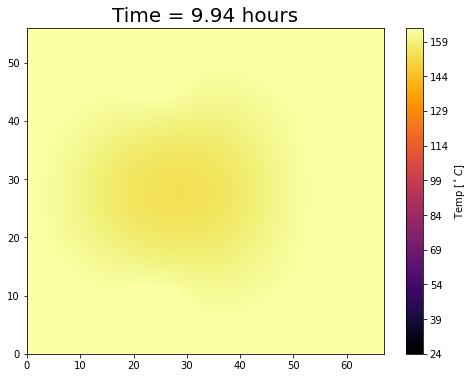

In [50]:
my_cmap = plt.get_cmap('inferno')
def init():
    a = ax.contourf(heat_frames[0][10], 100, cmap=my_cmap,
                    vmin=rawturk_temp-273.15, vmax = oven_temp-273.15)
    cbar = fig.colorbar(a)
    cbar.set_label('Temp [$^\circ C$]')

def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i][10], 100, cmap=my_cmap,
                vmin=rawturk_temp-273.15, vmax = oven_temp-273.15)
    ax.set_title('Time = {:.2f} hours'.format(100*i/3600), fontsize=20)
    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=359, interval=50)
ani.save('cooked.gif',writer='pillow',fps=30)

In [53]:
avg_temp = np.array([heat_frame[turkey_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[turkey_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[turkey_bool].std() for heat_frame in heat_frames]) 

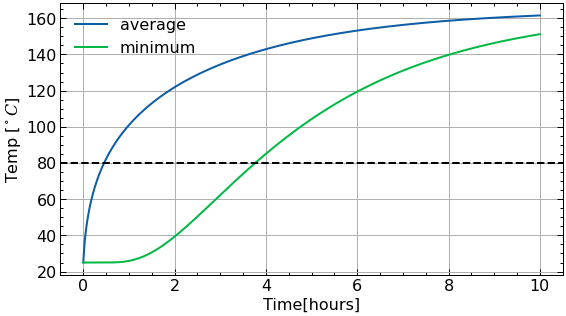

In [59]:
plt.figure(figsize=(9,5))
plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='minimum')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()
plt.legend()
plt.savefig('for_vid.png', dpi=200)